In [1]:
!nvidia-smi

Thu Sep 21 22:20:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0               16W /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import Neccessary Libraries

In [2]:
import os
import random
from collections import namedtuple
import time
import math
import pandas as pd
import numpy  as np
import cv2
from PIL import Image


# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from skimage.feature import local_binary_pattern

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import cycle
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize

from sklearn import svm
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

c:\Users\kings\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define seed to eneable reproducibility of results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
folders = os.listdir(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\train")

In [5]:
# Check the size of the data
train_total = []
val_total = []
for folder in folders:
  train_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\train"
  train_total.append(len(os.listdir(train_dir + "\\" + folder)))
    
  val_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\val"
  val_total.append(len(os.listdir(val_dir + "\\" + folder)))
print(f"Train Images--------- {sum(train_total)}\nValidation Images----------------- {sum(val_total)}")

test_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\test\Unknown"
print(f"Test Images----------- {len(os.listdir(test_dir))}")
print("")
print(f"Total number of Images: {sum(train_total) + sum(val_total) + (len(os.listdir(test_dir)))}")

Train Images--------- 20033
Validation Images----------------- 2856
Test Images----------- 5739

Total number of Images: 28628


In [6]:
batch_size = 16
transform_train = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    
    # Standardize each channel of the image
    transforms.Normalize([0.4567, 0.4567, 0.4567],
                                     [0.2425, 0.2425, 0.2425])
    ])

transform_test = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize([0.4567, 0.4567, 0.4567],
                                     [0.2425, 0.2425, 0.2425])
   ])

# Load the datatsets from each folder

In [7]:
data_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer"

train = datasets.ImageFolder(
    os.path.join(data_dir, 'fer_train_val_test', 'train'),
    transform=transform_train)

In [8]:
val, test = [datasets.ImageFolder(
    os.path.join(data_dir, 'fer_train_val_test', folder),
    transform=transform_test) for folder in ['val', 'test']]

In [9]:
train_iter = data.DataLoader(train, batch_size, shuffle=True, drop_last=True)

valid_iter = data.DataLoader(val, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = data.DataLoader(test, batch_size, shuffle=False,
                                        drop_last=False)

### This is an additional code to check the mean and standard deviation of your dataset - you can then use it to replace the values in transforms.Normalize to improve your work

In [10]:
# means = torch.zeros(3)
# stds = torch.zeros(3)

# for img, label in train:
#     means += torch.mean(img, dim = (1,2))
#     stds += torch.std(img, dim = (1,2))

# means /= len(train)
# stds /= len(train)
    
# print(f'Calculated means: {means}')
# print(f'Calculated stds: {stds}')

### Show image - display some of your images for observation.

In [11]:

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

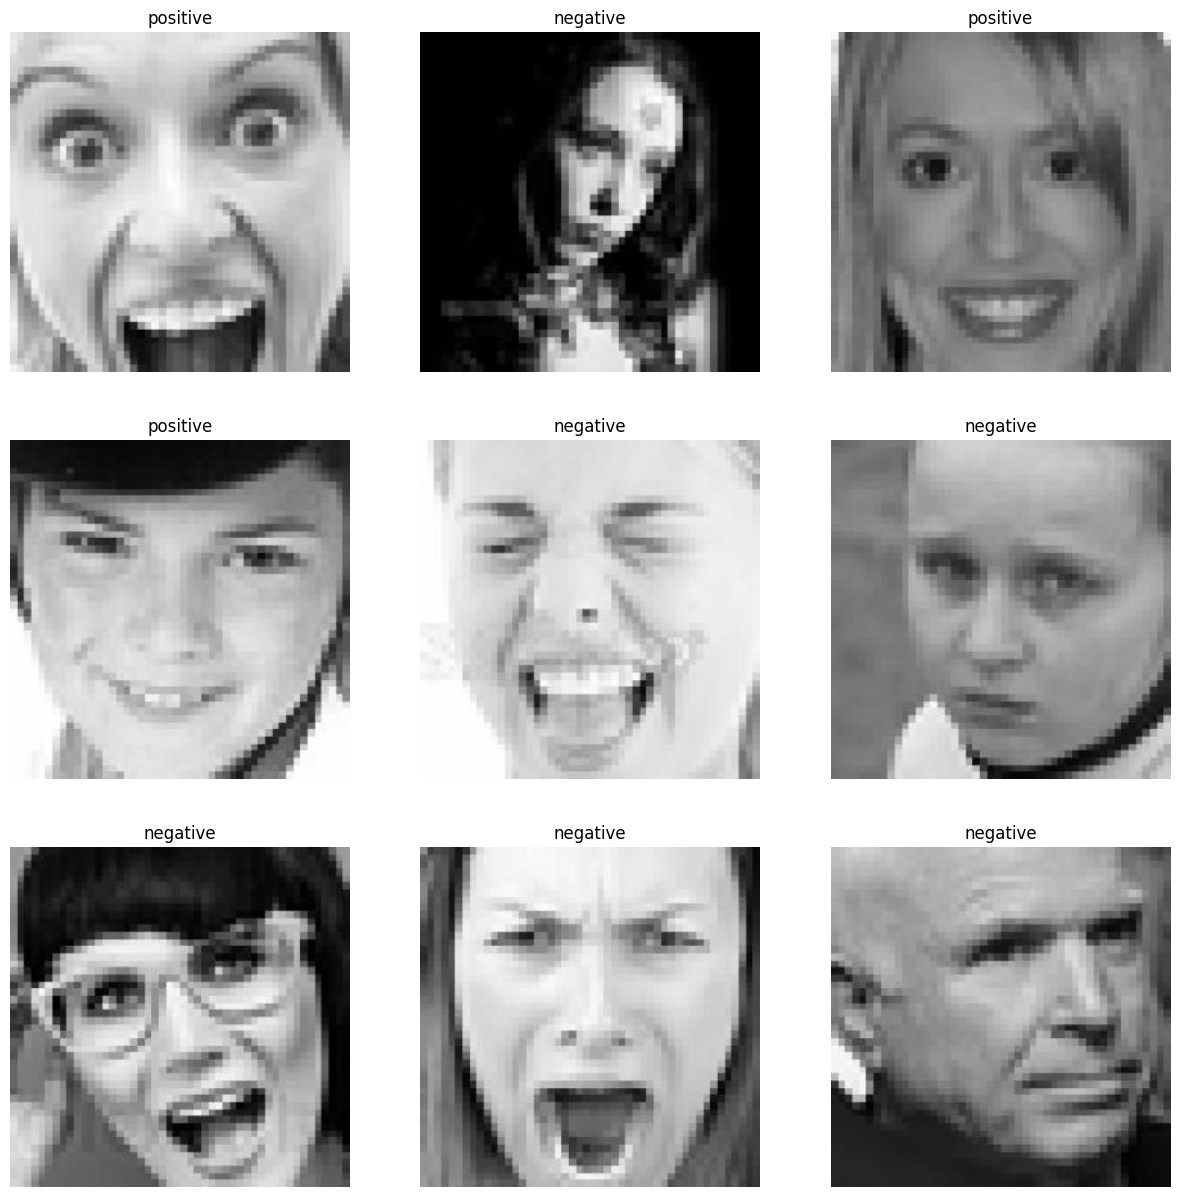

In [12]:
N_IMAGES = 10

images, labels = next(iter(train_iter))
image_label_pairs = list(zip(images, labels))
random.shuffle(image_label_pairs)
shuffled_images, shuffled_labels = zip(*image_label_pairs)
classes = train.classes

plot_images(shuffled_images[:N_IMAGES], shuffled_labels[:N_IMAGES], classes)

In [13]:
images[0].shape

torch.Size([3, 299, 299])

In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(train.classes))
model.eval

Using cache found in C:\Users\kings/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\kings\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kings\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<bound method Module.eval of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 

### Setting the hyperparameters and train the model

In [15]:
def count_parameters(model):
    return  __builtins__.sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 25,118,411 trainable parameters


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [17]:
FOUND_LR = 2e-4

params = [
    {'params': model.parameters(), 'lr': FOUND_LR}]
adam_opt = optim.Adam(params, lr=FOUND_LR)
sgd = optim.SGD(params, lr=FOUND_LR)
sgd_nesterov_opt = optim.SGD(params, lr=FOUND_LR,momentum=0.9, nesterov=True)

In [18]:
def changeepochs(epochs, opt):
    STEPS_PER_EPOCH = len(train_iter)
    TOTAL_STEPS = epochs * STEPS_PER_EPOCH

    MAX_LRS = [p['lr'] for p in opt.param_groups]

    scheduler = lr_scheduler.OneCycleLR(opt,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)
    return scheduler

In [19]:
scheduler = changeepochs(20, adam_opt)

In [20]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
def train_self(model, iterator, optimizer, criterion, device, scheduler=None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

In [23]:
def evaluate_self(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0

    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

In [24]:
def get_predictions_self(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [25]:
def run_self_model(EPOCHS, model, opt, scheduler=None):
    counter = 0
    patience = 10
    best_valid_loss = float('inf')
    best_epoch = 0
    best_val_acc = float('inf')
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []
    for epoch in range(EPOCHS):        
        start_time = time.monotonic()
        if scheduler:
            train_loss, train_acc = train_self(model, train_iter, opt, criterion, device, scheduler)
            valid_loss, valid_acc = evaluate_self(model, valid_iter, criterion, device)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_val_acc = valid_acc
                best_epoch = epoch
                filename = fr"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\{model.__class__.__name__}_{opt.__class__.__name__}no_aug.pt"
                torch.save(model.state_dict(), filename)
                counter = 0
            else:
                counter += 1  # increase patience counter on no improvement
                if counter >= patience:
                    print(f"Validation loss hasn't improved in {patience} epochs. Stopping early.")
                    break
        else:
            train_loss, train_acc = train_self(model, train_iter, opt, criterion, device)
            valid_loss, valid_acc = evaluate_self(model, valid_iter, criterion, device)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_val_acc = valid_acc
                best_epoch = epoch
                filename = fr"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\{model.__class__.__name__}_{opt.__class__.__name__}no_aug.pt"
                torch.save(model.state_dict(), filename)
                counter = 0
            else:
                counter += 1  # increase patience counter on no improvement
                if counter >= patience:
                    print(f"Validation loss hasn't improved in {patience} epochs. Stopping early.")
                    break

        

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}% |")
        print(f"\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}% |")
    print(f"best epcoh: {best_epoch+1}, best _validation accuracy: {best_val_acc}, best Validation loss: {best_valid_loss}")
    return train_accs, valid_accs, train_losses, valid_losses

In [26]:
train_accs, valid_accs, train_losses, valid_losses = run_self_model(20, model, adam_opt, scheduler)

Epoch: 01 | Epoch Time: 14m 23s
	Train Loss: 0.804 | Train Acc:  63.49% |
	Valid Loss: 0.530 | Valid Acc:  78.51% |
Epoch: 02 | Epoch Time: 13m 28s
	Train Loss: 0.479 | Train Acc:  79.96% |
	Valid Loss: 0.434 | Valid Acc:  82.87% |
Epoch: 03 | Epoch Time: 13m 46s
	Train Loss: 0.385 | Train Acc:  84.54% |
	Valid Loss: 0.414 | Valid Acc:  83.57% |
Epoch: 04 | Epoch Time: 182m 1s
	Train Loss: 0.349 | Train Acc:  85.99% |
	Valid Loss: 0.460 | Valid Acc:  81.21% |
Epoch: 05 | Epoch Time: 266m 27s
	Train Loss: 0.325 | Train Acc:  87.05% |
	Valid Loss: 0.450 | Valid Acc:  82.97% |
Epoch: 06 | Epoch Time: 13m 53s
	Train Loss: 0.292 | Train Acc:  88.66% |
	Valid Loss: 0.495 | Valid Acc:  81.81% |
Epoch: 07 | Epoch Time: 13m 38s
	Train Loss: 0.251 | Train Acc:  90.23% |
	Valid Loss: 0.432 | Valid Acc:  83.18% |
Epoch: 08 | Epoch Time: 13m 11s
	Train Loss: 0.198 | Train Acc:  92.43% |
	Valid Loss: 0.508 | Valid Acc:  83.11% |
Epoch: 09 | Epoch Time: 13m 15s
	Train Loss: 0.154 | Train Acc:  94.43%

In [27]:
def plot_loss_acc():
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(valid_losses, label='Validation Loss')
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_title("Train vs Validation Loss", weight="bold")
    ax[0].legend()

    ax[1].plot(train_accs, label='Training Accuracy')
    ax[1].plot(valid_accs, label='Validation Accuracy')
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[1].set_title("Train vs Validation Accuracy", weight="bold")
    ax[1].legend();
    plt.show()

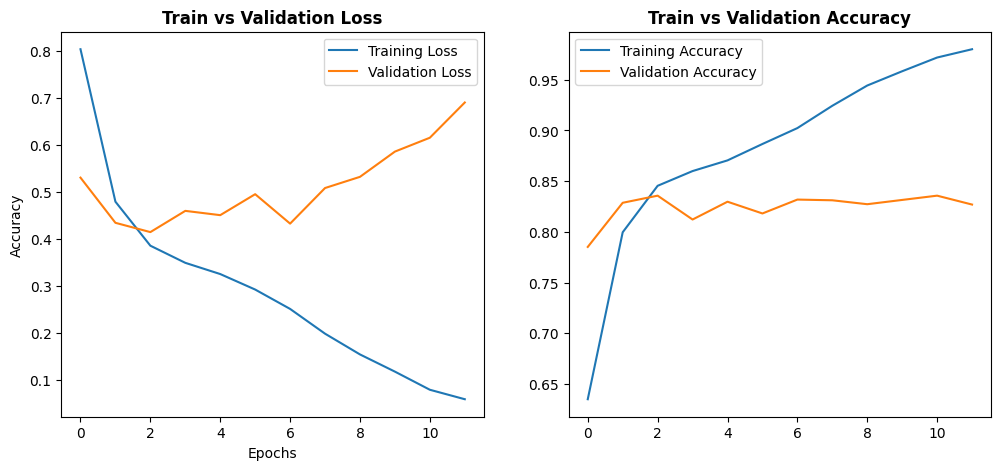

In [28]:
plot_loss_acc()

In [31]:
state_dict = torch.load(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\Inception3_Adamno_aug.pt")

model.load_state_dict(state_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval


<bound method Module.eval of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 

In [32]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred= model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [33]:
from scipy import interp
def plot_roc_curves(y_test, probs, class_labels):
    n_classes = len(class_labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i, label in enumerate(class_labels):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(label, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of Proposed Method')
    plt.legend(loc="lower right")
    plt.show()


In [34]:
images, labels, probs = get_predictions(model, test_iter)

In [35]:
test = pd.read_csv(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\GroundTruth.csv")
y_test = np.array(test.drop(['id'], axis=1))
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

In [36]:
class_names = unique_labels(true_class, pred_class)
class_names

array([0, 1, 2], dtype=int64)

In [37]:
y_test.shape

(5739, 3)

In [38]:
probs.shape

torch.Size([5739, 3])

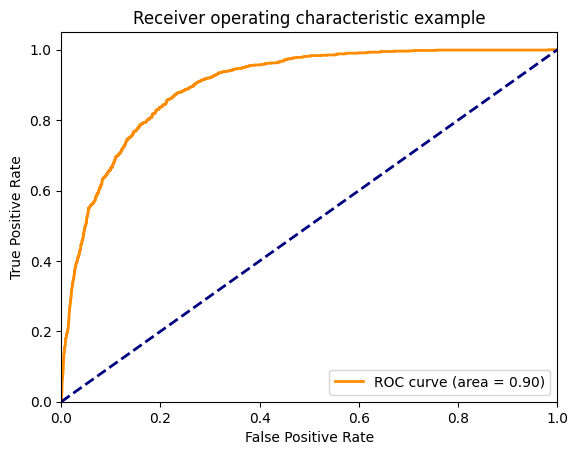

C:\Users\kings\AppData\Local\Temp\ipykernel_1052\3032910195.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


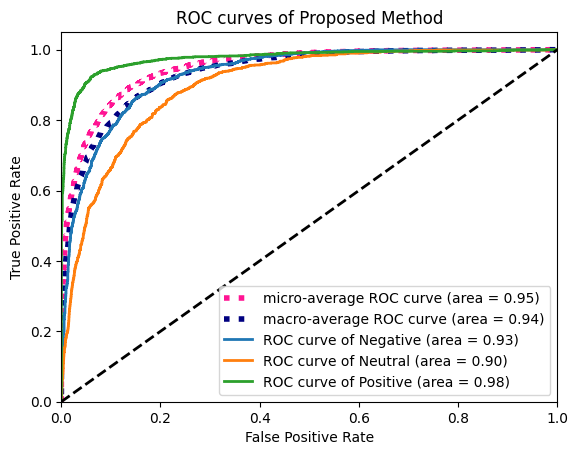

In [39]:
class_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
class_names = [class_dict[label] for label in class_names]
plot_roc_curves(y_test, probs, class_names)

In [40]:
print(test['negative'].sum())
print(test['neutral'].sum())
print(test['positive'].sum())

2912
1015
1812


In [41]:
def plot_cm_class_report():
    cm=confusion_matrix(true_class, pred_class)
    class_names = unique_labels(true_class, pred_class)
    class_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    class_names = [class_dict[label] for label in class_names]
    print(cm)
    print(class_names)

    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    C = cm
    divisor = np.zeros((3,3))
    divisor[0][:] = 2745
    divisor[1][:] = 1001
    divisor[2][:] = 1755
    cm_normalised=np.divide(cm, divisor)
    print(np.transpose(C.sum(axis=1)))
    print(divisor)
    cm_normalised = np.round(cm_normalised, 2)
    disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='');
    print(classification_report(true_class, pred_class))

[[2433  340  139]
 [ 289  644   82]
 [  97   62 1653]]
['Negative', 'Neutral', 'Positive']
[2912 1015 1812]
[[2745. 2745. 2745.]
 [1001. 1001. 1001.]
 [1755. 1755. 1755.]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2912
           1       0.62      0.63      0.62      1015
           2       0.88      0.91      0.90      1812

    accuracy                           0.82      5739
   macro avg       0.79      0.79      0.79      5739
weighted avg       0.83      0.82      0.82      5739



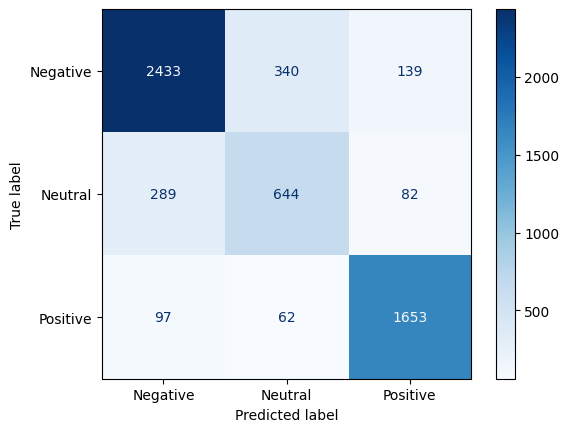

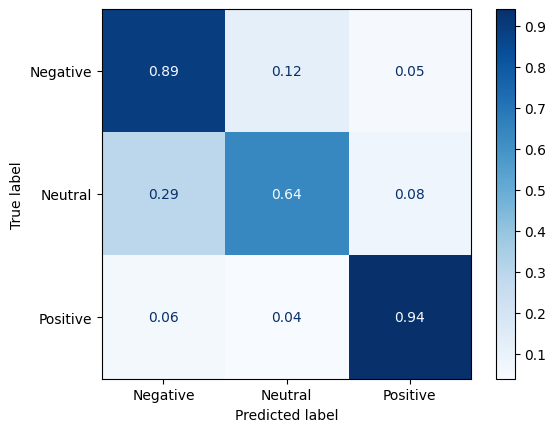

In [42]:
plot_cm_class_report()

In [43]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.6)

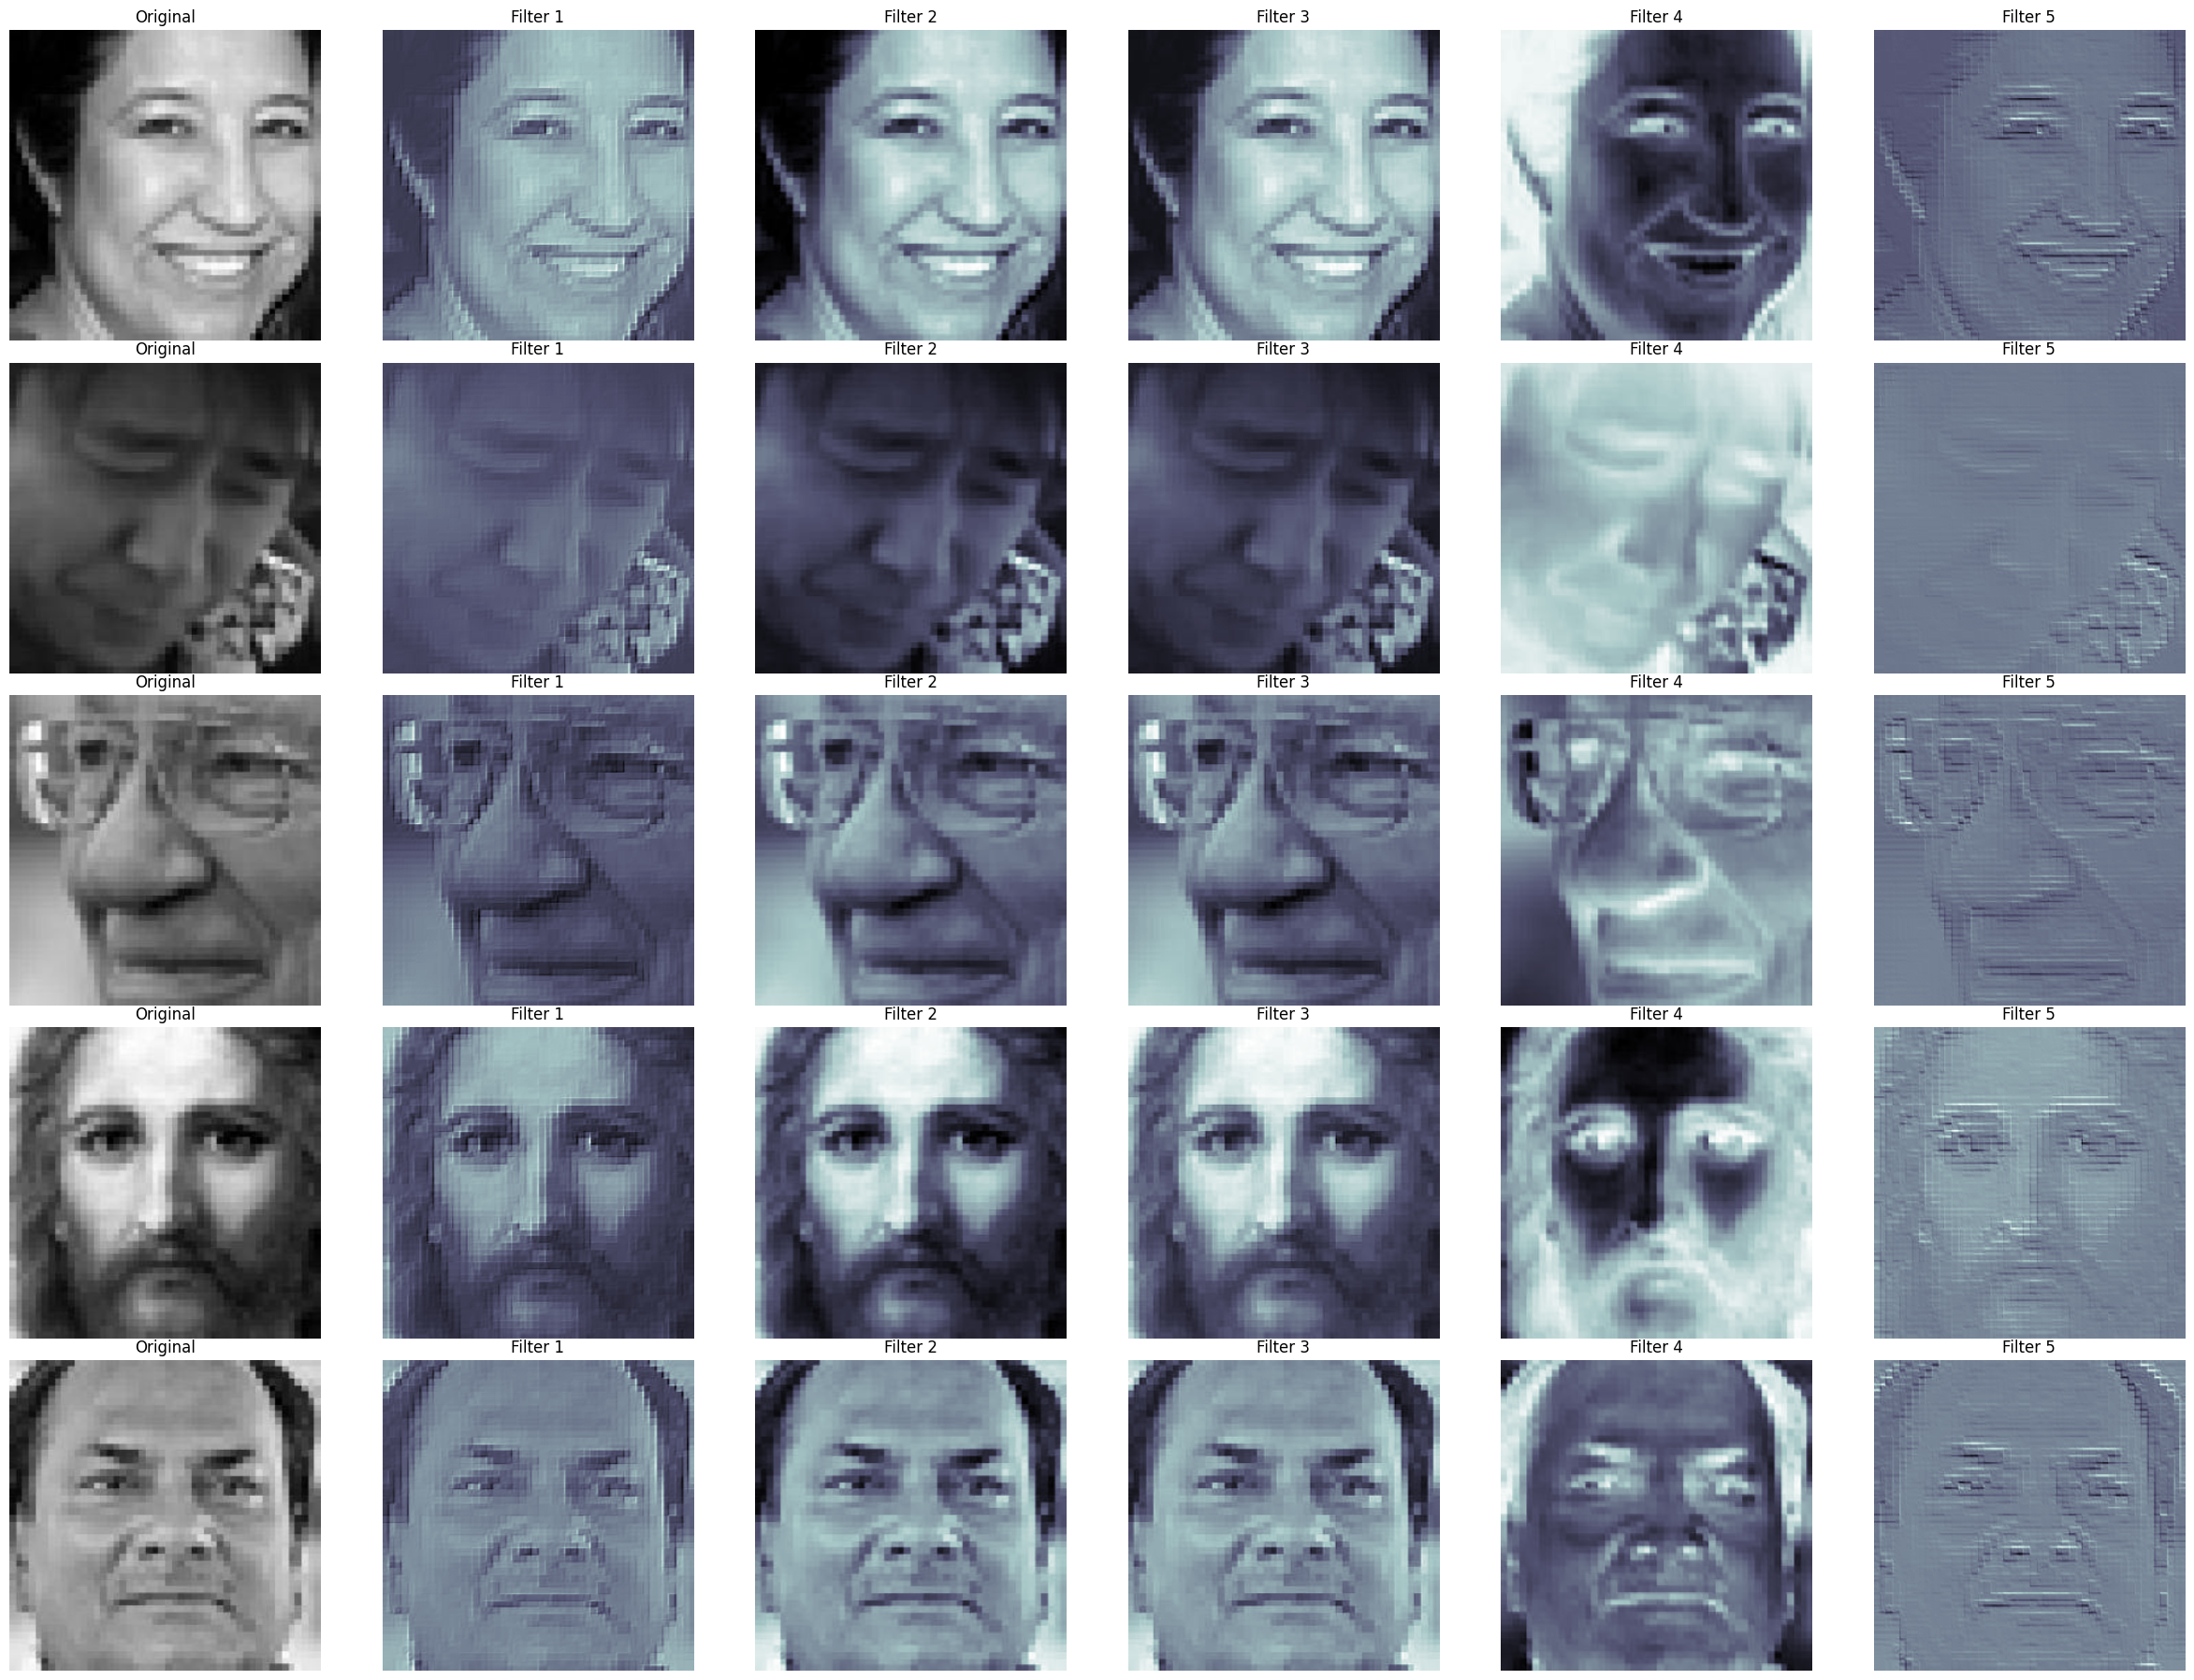

In [47]:
N_IMAGES = 5
N_FILTERS = 5


images, labels = next(iter(train_iter))
image_label_pairs = list(zip(images, labels))
random.shuffle(image_label_pairs)
shuffled_images, shuffled_labels = zip(*image_label_pairs)
classes = train.classes

images = [image for image, label in [train[i] for i in range(N_IMAGES)]]
filters = model.Conv2d_1a_3x3.conv.weight.data
plot_filtered_images(shuffled_images[:N_IMAGES], filters, N_FILTERS)